In [1]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

run_names = {
    "aviti_ngi": "AVITI CB FS",
    "aviti_hq": "AVITI CB",
    "xplus_sns": "NovaSeqX+",
}

custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(
    context="notebook",
    style="ticks", 
    palette="colorblind",
    font_scale=1.1,
    rc=custom_params
)

basedir = Path("../analysis/differential_coverage")

# For SVG output
plt.rcParams['svg.fonttype'] = 'none'
figdir = Path("../figures/svg")


In [2]:
def load_data(tsv):
    data = pd.read_csv(tsv, sep='\t')

    data = data.melt(var_name='Stratification', value_name='Bases', id_vars='depth')
    data["Norm"] = data.groupby("Stratification")["Bases"].transform(lambda x: x / x.sum())
    data["NormMax"] = data.groupby("Stratification")["Bases"].transform(lambda x: x / x.max())
    data["CumulativeNorm"] = data.groupby("Stratification")["Norm"].transform(lambda x: x.cumsum())
    
    data = data[~data["Stratification"].str.startswith("chrY")]
    data = data[~data["Stratification"].str.startswith("chrX")]
    return data

def files():
    runs = ["aviti_ngi", "aviti_hq", "xplus_sns"]
    cells = ["KMS12BM", "MM1S", "OPM2", "REH"]

    for run in runs:
        for cell in cells:
            file = basedir / "histogram" / f"{run}_{cell}.tsv"
            yield run, cell, file

data = []
for run, cell, file in files():
    d = load_data(file)
    d["run"] = run
    d["Cell line"] = cell
    d["Data source"] = d["run"].replace(run_names)
    data.append(d)

data = pd.concat(data).reset_index(drop=True)

data.loc[data["Stratification"].str.startswith("SimpleRepeat"),"Stratification"] = data[data["Stratification"].str.startswith("SimpleRepeat")]["Stratification"].apply(lambda x: "_".join(x.split("_")[1:]))
data["Stratification"] = data["Stratification"].astype("category")
data.head()

,depth,Stratification,Bases,Norm,NormMax,CumulativeNorm,run,Cell line,Data source
0,0,G4,3055404.0,0.072254,1.000000,0.072254,aviti_ngi,KMS12BM,AVITI CB FS
1,1,G4,1070401.0,0.025313,0.350330,0.097567,aviti_ngi,KMS12BM,AVITI CB FS
2,2,G4,1291576.0,0.030543,0.422719,0.128110,aviti_ngi,KMS12BM,AVITI CB FS
3,3,G4,1631679.0,0.038586,0.534031,0.166696,aviti_ngi,KMS12BM,AVITI CB FS
4,4,G4,2015141.0,0.047654,0.659533,0.214349,aviti_ngi,KMS12BM,AVITI CB FS


/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_63680/2223349834.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d = data.groupby(["Data source", "Cell line", "Stratification"], as_index=False)["Bases"].sum()


['diTR_ge150_slop5', 'homopolymer_ge21_GC_slop5', 'quadTR_ge150_slop5', 'triTR_ge150_slop5']


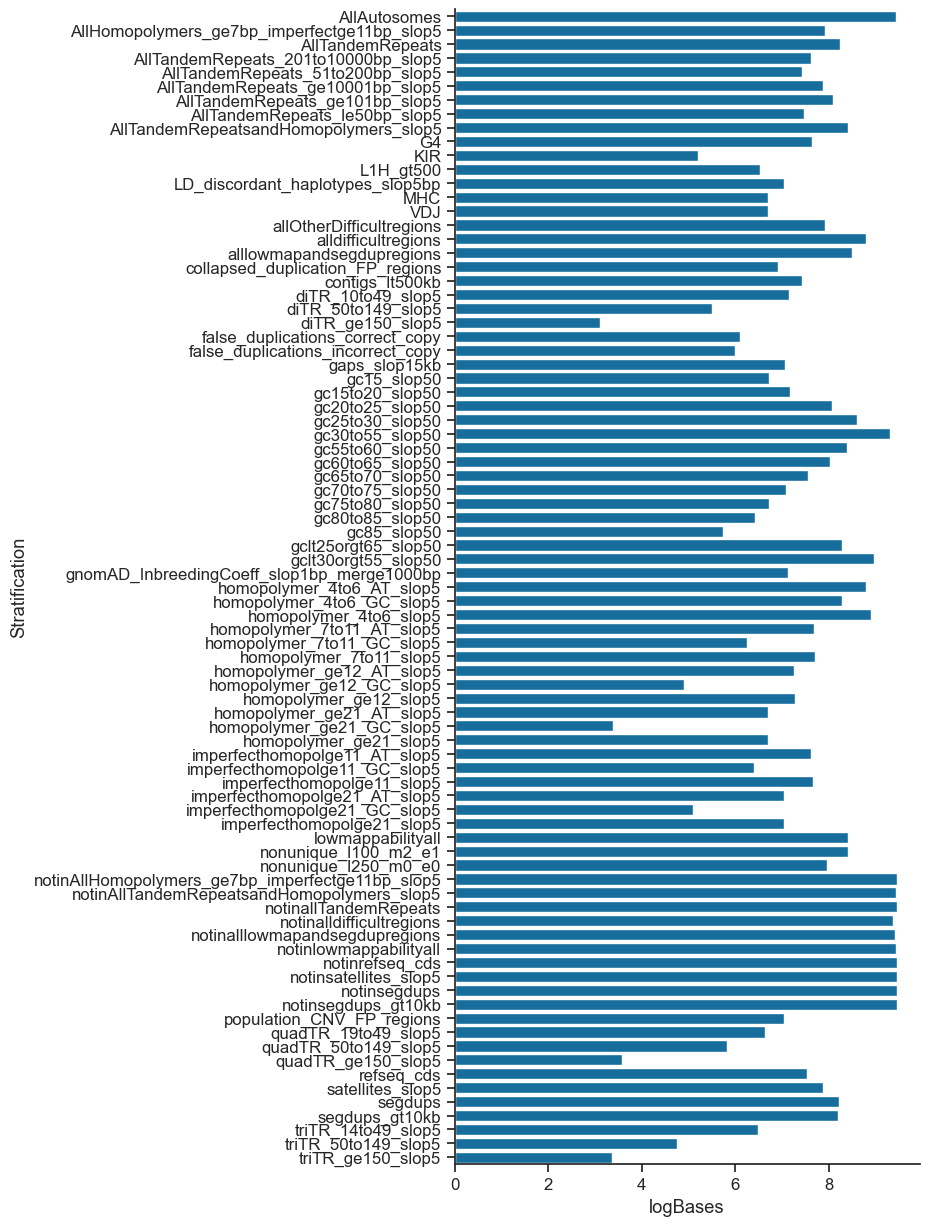

In [3]:
d = data.groupby(["Data source", "Cell line", "Stratification"], as_index=False)["Bases"].sum()
d["logBases"] = d["Bases"].apply(np.log10)
print(d[d["Bases"] < 10_000]["Stratification"].unique().tolist())
d = d.sort_values(by="Bases")
fig, ax = plt.subplots(figsize=(6,15))
ax = sns.barplot(d, y="Stratification", x="logBases", ax=ax)

## Autosomal chromosome coverage

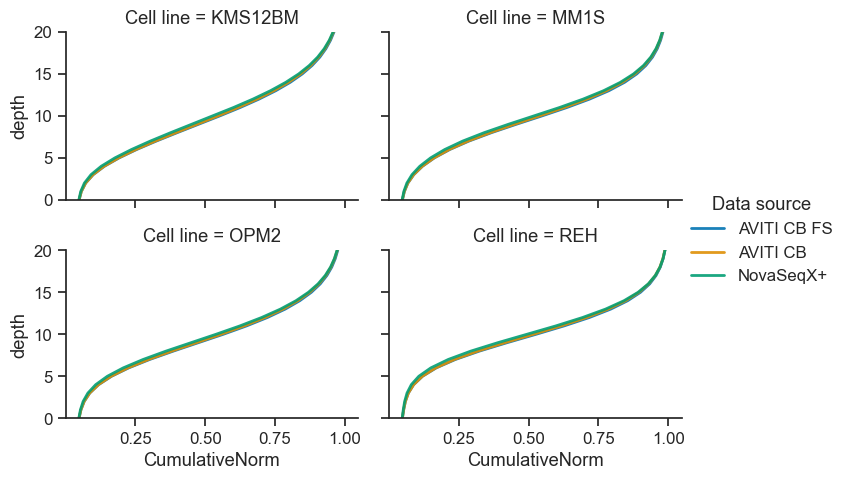

In [4]:
d = data.query("Stratification == 'AllAutosomes'")
g = sns.relplot(kind="line", data=d, y="depth", x="CumulativeNorm", 
                col="Cell line", lw=2, hue="Data source", height=2.5, aspect=1.5,
                col_wrap=2, alpha=0.9, )
g.set(ylim=(0,20))


Coverage is even across Data sources

## Differential covergage
### Top stratifications by inter-cell line variability across datasets

In [5]:
import scipy.interpolate
def coverage_stats(x):
    mean = (x["depth"] * x["Bases"]).sum() / x["Bases"].sum()

    # Median
    y_interp = scipy.interpolate.interp1d(x["CumulativeNorm"], x["depth"])
    if x["CumulativeNorm"].min() > 0.5:
        median = 0
    else:
        median = y_interp(0.5)    

    # AUC
    auc = np.trapezoid(x=x["CumulativeNorm"], y=x["depth"])
    
    return pd.Series(dict(
        mean=mean,
        median=median,
        auc=auc,
    ))

d = data.copy().reset_index()

# Ignore startifications with low coverage as this increases random variations
ds = data.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False)["Bases"].sum()
strats_removed = ds[ds["Bases"] < 10000]["Stratification"].unique().tolist()
strats_removed += ["G4"] # ignore G4 motifs for now
d = d[~d["Stratification"].isin(strats_removed)]


stats = d.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False).apply(coverage_stats)
stats = stats[~stats["mean"].isna()]

stats_list = ["mean", "median", "auc"]
stats_to_strats = {}
for stat in stats_list:
    var = stats.groupby(["Stratification", "Cell line"], as_index=False, observed=False)[stat].var()
    strats = var.sort_values(by=stat, ascending=False)["Stratification"].unique().tolist()#[:50]
    stats_to_strats[stat] = strats
    print(stat, "\t", strats)


mean 	 ['gc85_slop50', 'gc80to85_slop50', 'gc75to80_slop50', 'quadTR_50to149_slop5', 'imperfecthomopolge21_GC_slop5', 'homopolymer_ge12_GC_slop5', 'imperfecthomopolge11_GC_slop5', 'gc70to75_slop50', 'triTR_50to149_slop5', 'homopolymer_ge21_AT_slop5', 'homopolymer_ge21_slop5', 'gc65to70_slop50', 'diTR_50to149_slop5', 'homopolymer_7to11_GC_slop5', 'quadTR_19to49_slop5', 'imperfecthomopolge21_AT_slop5', 'imperfecthomopolge21_slop5', 'gc15to20_slop50', 'homopolymer_ge12_AT_slop5', 'homopolymer_ge12_slop5', 'gc60to65_slop50', 'gc15_slop50', 'gc20to25_slop50', 'false_duplications_correct_copy', 'diTR_10to49_slop5', 'AllTandemRepeats_51to200bp_slop5', 'gc25to30_slop50', 'AllTandemRepeats_201to10000bp_slop5', 'KIR', 'triTR_14to49_slop5', 'imperfecthomopolge11_slop5', 'LD_discordant_haplotypes_slop5bp', 'imperfecthomopolge11_AT_slop5', 'homopolymer_7to11_slop5', 'refseq_cds', 'homopolymer_7to11_AT_slop5', 'AllHomopolymers_ge7bp_imperfectge11bp_slop5', 'homopolymer_4to6_AT_slop5', 'gc55to60_slop

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_63680/3511257208.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stats = d.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False).apply(coverage_stats)


<Axes: xlabel='order', ylabel='index'>

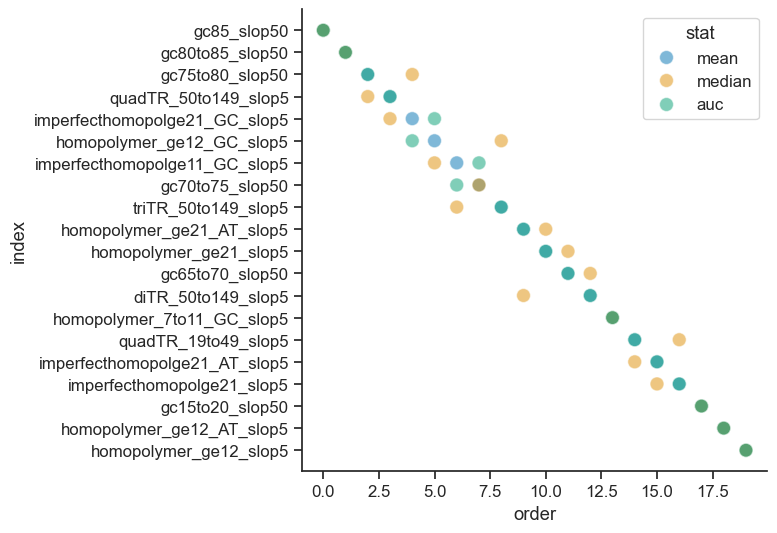

In [6]:
d = []
for k, v in stats_to_strats.items():
    d.append(
        pd.DataFrame(
            index=v,
            data={k: range(len(v))}
        )
    )
d = pd.concat(d, axis=1).head(20)
d = d.melt(var_name="stat", value_name="order", ignore_index=False).reset_index()
fig, ax = plt.subplots(figsize=(6,6))
sns.scatterplot(
    d, x="order", y="index", hue="stat", s=100, alpha=0.5
)


The top15 are, more or less, the same for different summary metrics, using mean.

### Plot Top15 variable stratifications in relation to AllAutosomal (baseline)

In [7]:
stats_to_strats["mean"][:15]

['gc85_slop50',
 'gc80to85_slop50',
 'gc75to80_slop50',
 'quadTR_50to149_slop5',
 'imperfecthomopolge21_GC_slop5',
 'homopolymer_ge12_GC_slop5',
 'imperfecthomopolge11_GC_slop5',
 'gc70to75_slop50',
 'triTR_50to149_slop5',
 'homopolymer_ge21_AT_slop5',
 'homopolymer_ge21_slop5',
 'gc65to70_slop50',
 'diTR_50to149_slop5',
 'homopolymer_7to11_GC_slop5',
 'quadTR_19to49_slop5']

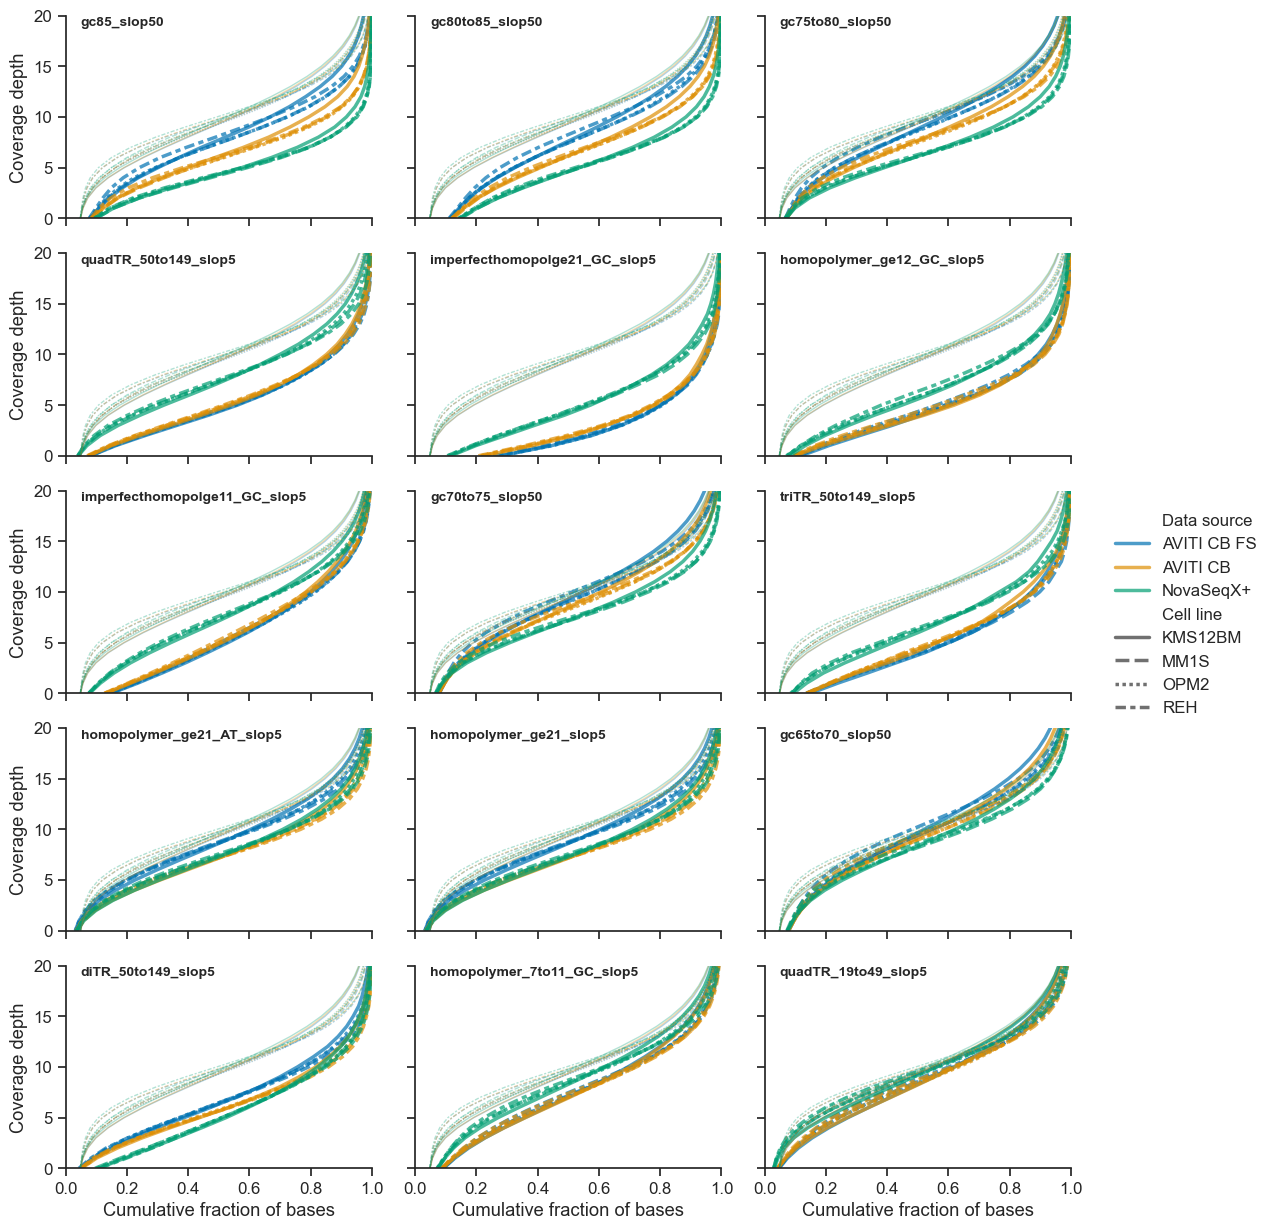

In [8]:
strats = stats_to_strats["mean"][:15]
d = data[data["Stratification"].isin(strats)]
g = sns.relplot(kind="line", data=d, y="depth", x="CumulativeNorm", hue_order=run_names.values(),
                col="Stratification", lw=2.5, hue="Data source", style="Cell line", height=2.5, aspect=1.5,
                col_wrap=3, alpha=0.7, facet_kws=dict(sharey=True, sharex=True), col_order=strats)

g.set(ylim=(0,20), xlim=(0,1), xlabel="Cumulative fraction of bases", ylabel="Coverage depth")

for s, ax in g.axes_dict.items():
    # Add the title as an annotation within the plot
    ax.text(.05, .95, s, transform=ax.transAxes, fontweight="bold", size=10)

    sns.lineplot(data[data["Stratification"] == "AllAutosomes"], y="depth", x="CumulativeNorm", estimator=None, 
                 lw=1, hue="Data source", style="Cell line", ax=ax, alpha=0.3, legend=False)
g.set_titles(col_template="")
g.tight_layout()

/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_63680/2929280413.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  d = d.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False).apply(mean_coverage)
/var/folders/9f/8ggsf77s7hx0xcdvhzs8pfjx0t5xky/T/ipykernel_63680/2929280413.py:35: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  d["s"] = d["Stratification"].replace(s_to_s)


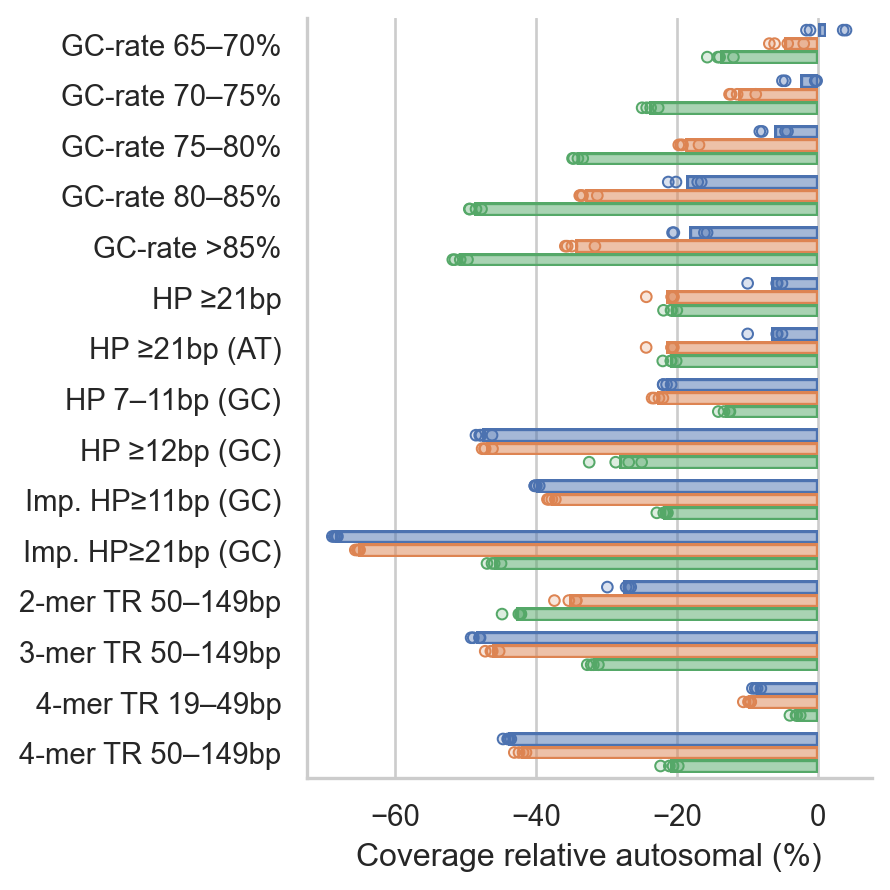

In [9]:
s_to_s = {
    'gc65to70_slop50': 'GC-rate 65–70%',
    'gc70to75_slop50': 'GC-rate 70–75%',
    'gc75to80_slop50': 'GC-rate 75–80%',
    'gc80to85_slop50': 'GC-rate 80–85%',
    'gc85_slop50': 'GC-rate >85%',
    'homopolymer_ge21_slop5': 'HP ≥21bp',    
    'homopolymer_ge21_AT_slop5': 'HP ≥21bp (AT)',
    'homopolymer_7to11_GC_slop5': 'HP 7–11bp (GC)',
    'homopolymer_ge12_GC_slop5': 'HP ≥12bp (GC)',
    'imperfecthomopolge11_GC_slop5': 'Imp. HP≥11bp (GC)',
    'imperfecthomopolge21_GC_slop5': 'Imp. HP≥21bp (GC)',
    'diTR_50to149_slop5': '2-mer TR 50–149bp',
    'triTR_50to149_slop5': '3-mer TR 50–149bp',
    'quadTR_19to49_slop5': '4-mer TR 19–49bp',
    'quadTR_50to149_slop5': '4-mer TR 50–149bp',    
}
strats = list(s_to_s.keys())
strats_wauto = strats + ["AllAutosomes"]

d = data[data["Stratification"].isin(strats_wauto)]
def mean_coverage(x):
    mean = (x["depth"] * x["Bases"]).sum() / x["Bases"].sum()
    return pd.Series(dict(
        mean=mean,
    ))    

d = d.groupby(["Data source", "Cell line", "Stratification"], as_index=False, observed=False).apply(mean_coverage)
d = d.pivot(index=["Data source", "Cell line"], columns="Stratification", values="mean")
d = d[strats_wauto]
d = d.apply(lambda x: 100 * x / x["AllAutosomes"] - 100, axis=1)
d = d[strats]
d = d.melt(var_name="Stratification", value_name="mean", ignore_index=False).reset_index()

d["s"] = d["Stratification"].replace(s_to_s)
order = [s_to_s[s] for s in strats]

p = (
    so.Plot(data=d, x="mean", y="s", color="Data source")#, group="Cell line")
    .add(so.Bar(alpha=0.5), so.Est("mean"), so.Dodge(by=["color"], gap=0), legend=False)

    # Plot cells
    .add(so.Dots(pointsize=4, alpha=1), so.Dodge(by=["color"], gap=0), legend=False)

    # Adjust aesthetics
    .scale(
        color=so.Nominal(order=list(run_names.values())),
        marker=so.Nominal(order=sorted(d["Cell line"].unique())),
        y=so.Nominal(order=order),
    )
    .layout(size=(4.8, 4.8), engine="tight")#, extent=[0, 0, 0.9, 1])
    .theme(sns.axes_style("whitegrid") | sns.plotting_context("notebook"))
    .theme(custom_params)
    .label(
        x="Coverage relative autosomal (%)",
        y="",
    )
    .save(figdir / "coverage_relative_autosomal_top_ordered.svg",
          dpi=300, bbox_inches="tight", transparent=True)
)
p
